In [12]:
import pickle
import pandas as pd 
from tensorboard_reducer import load_tb_events, reduce_events, write_csv, write_tb_events
import yaml
import glob

def get_events(version_num, path_to_ver):
    if isinstance(version_num, (str, int)):
        version_num = [version_num]    
    events_files = []
    for v in version_num:
        events_file = path_to_ver + '/version_%s' % v
        events_files.append(events_file)
    events = load_tb_events(events_files, handle_dup_steps='keep-last')
    return events

def get_class_label_sentence(k, idx2class):
    class_num = re.search('Class (\d)', k)
    class_found = False
    if class_num is not None:
        class_found = True
        class_num = class_num[1]
        class_name = ' %s ' % idx2class[int(class_num)]
        class_name = ' '.join(class_name.split())
        k = k.replace('Class %s' % class_num, class_name)
    return k, class_found
                
def get_sentence_results_single_task(add_vers, ref_vers, op_vers, path_to_ver, trail_name):
    op = {
        op_vers: 'Operations binary',
        ref_vers: 'Refactor binary',
        add_vers: 'Add binary',
    }

    op_mapper = {
        op_vers: op_class2idx,
        ref_vers: ref_class2idx,
        add_vers: add_class2idx,
    }
    
    new_results_dict = {}
    for e in [add_vers, ref_vers, op_vers]:
        events_dict = get_events(e, path_to_ver)
        for k in events_dict:
            idx2class = op_mapper[e]
            k_orig = k
            k, found = get_class_label_sentence(k, idx2class)
            if 'Loss' not in k:
                v = events_dict[k_orig].max()
                new_results_dict[(trail_name, op[e] + ': ' + k)] = float(v)
            else:
                new_results_dict[(trail_name, op[e] + ': ' + k)] = events_dict[k_orig]['value'].tolist()
    return new_results_dict

In [24]:
path_to_ver = '../modeling/tensorboard/old_architecture/default'
version_num_to_notes = {}
hparams_dict = {}
for hparams_file in glob.glob(path_to_ver + '/*/hparams.yaml'):
    version_num = hparams_file.split('/')[-2]
    with open(hparams_file, "r") as stream:
        hparams = yaml.safe_load(stream)
        version_num_to_notes[version_num] = hparams.get('notes')
        hparams_dict[version_num] = hparams
        
version_map_s = pd.Series(version_num_to_notes)

pd.options.display.max_colwidth=200

(version_map_s
 .reset_index()
 .assign(index=lambda df: df['index'].str.split('_').str.get(1).astype(int)).sort_values('index')
 .dropna()
 .set_index('index')[0]
)

index
0                         Roberta, Sentence Operations binary, high level labels
1                         Roberta, Sentence Operations binary, high level labels
2                                Roberta, Sentence Add binary, high level labels
3                         Roberta, Sentence Operations binary, high level labels
4                                Roberta, Sentence Add binary, high level labels
5                         Roberta, Sentence Operations binary, high level labels
6                           Roberta, Sentence Refactor binary, high level labels
7                                Roberta, Sentence Add binary, high level labels
8                                Roberta, Sentence Add binary, high level labels
9                         Roberta, Sentence Operations binary, high level labels
10                          Roberta, Sentence Refactor binary, high level labels
11                                Roberta, Sentence Operations binary, attention
12                 Rob

In [25]:
# Roberta, Sentence Add binary, attention, 1-6 Unfrozen, +Version +Multitask
# Roberta, Sentence Add binary, attention, 1-6 Unfrozen, +Multitask

# Roberta, Sentence Add binary, attention, 1-6 Unfrozen, +Multitask
# Roberta, Sentence Add binary, attention, 1-6 Unfrozen, +Version +Multitask

In [26]:
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

In [27]:
# pd.DataFrame(hparams_dict).T.fillna(False).loc[lambda df: ~df['freeze_transformer']].T

In [28]:
# 20               Roberta, Sentence Add binary, attention, 1-6 Unfrozen, +Version
# 21          Roberta, Sentence Refactor binary, attention, 1-6 Unfrozen, +Version
# 24        Roberta, Sentence Operations binary, attention, 1-6 Unfrozen, +Version

# 25                  Roberta, Sentence Add binary, attention, 1-6 Unfrozen, -LSTM
# 26           Roberta, Sentence Operations binary, attention, 1-6 Unfrozen, -LSTM
# 27             Roberta, Sentence Refactor binary, attention, 1-6 Unfrozen, -LSTM

# 34    Roberta, Sentence Add binary, attention, 1-6 Unfrozen, +Version +Multitask
# 35             Roberta, Sentence Add binary, attention, 1-6 Unfrozen, +Multitask

In [29]:
import re
add_class2idx = sorted(['Add Below', 'Add Above', 'Unchanged'])
ref_class2idx = sorted(['Refactored', 'Not Refactored'])
op_class2idx = sorted(['Edited', 'Unchanged', 'Deleted'])
micro_macro_names = ['Refactor Changes', 'Add', 'Sentence Changes']

In [75]:
add_events_dict = get_events(20, path_to_ver)

In [35]:
events_dict = get_events(34, path_to_ver)

In [79]:
tasks = ['refactor', 'add', 'sentence_ops']
task_class_mapper = [ref_class2idx, add_class2idx, op_class2idx]

def handle_k_multitask(k):
    k = k.replace('Validation:', '')
    task_idx = int(re.search('Task (\d)', k)[1])
    idx2name = task_class_mapper[task_idx]
    k, found = get_class_label_sentence(k, idx2name)    
    if found == False:
        m_name = micro_macro_names[task_idx]
        k = re.sub('Task (\d)', m_name, k)
    return k 
    
    
mt_eval = (pd.Series(events_dict).reset_index()
 .loc[lambda df: df['index'].str.contains('Validation')]
 .loc[lambda df: ~df['index'].str.contains('loss')]
 .loc[lambda df: df['index'].str.contains('F1')]
 .assign(val=lambda df: df[0].apply(lambda x: x.iloc[0,0]))
 .drop(0, axis=1)
 .assign(index=lambda df: df['index'].apply(handle_k_multitask))
)

In [80]:
col_order= [
#     'Task 0,  Not Refactored F1',
#     'Task 0,  Refactored F1',
    'Task 1,  Add Above F1', 
    'Task 1,  Add Below F1',
#     'Task 1,  Unchanged F1',
    'Add,  Macro F1', 
    'Add,  Weighted F1',
#     'Task 2,  Deleted F1',
#     'Task 2,  Edited F1', 'Task 2,  Unchanged F1',
    'Sentence Changes,  Macro F1',
    'Sentence Changes,  Weighted F1',
    'Refactor Changes,  Macro F1', 
    'Refactor Changes,  Weighted F1',
]

In [81]:
mt_eval.set_index('index').T

index,"Task 0, Not Refactored F1","Task 0, Refactored F1","Refactor Changes, Macro F1","Refactor Changes, Weighted F1","Task 1, Add Above F1","Task 1, Add Below F1","Task 1, Unchanged F1","Add, Macro F1","Add, Weighted F1","Task 2, Deleted F1","Task 2, Edited F1","Task 2, Unchanged F1","Sentence Changes, Macro F1","Sentence Changes, Weighted F1"
val,0.996489,0.0,0.498245,0.989517,0.0,0.0,0.92671,0.308903,0.800148,0.0,0.824514,0.0,0.274838,0.578334


In [82]:
t = mt_eval.set_index('index').T[col_order].pipe(lambda s: s*100).round(1)

In [83]:
print(t.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
index &  Task 1,  Add Above F1 &  Task 1,  Add Below F1 &  Add,  Macro F1 &  Add,  Weighted F1 &  Sentence Changes,  Macro F1 &  Sentence Changes,  Weighted F1 &  Refactor Changes,  Macro F1 &  Refactor Changes,  Weighted F1 \\
\midrule
val &                    0.0 &                    0.0 &            30.9 &               80.0 &                         27.5 &                            57.8 &                         49.8 &                            99.0 \\
\bottomrule
\end{tabular}



In [84]:
sent_unfro_dict = get_sentence_results_single_task(25, 27, 26, path_to_ver, '+Partially Unfrozen')
# need +Contextual
sent_version_dict = get_sentence_results_single_task(20, 21, 24, path_to_ver, '+Version')

In [85]:
# Additions Above, F1
# Additions Below, F1
# Sentence Changes, Macro
# Sentence Changes, Weighted
# Refactor Changes, Macro &  Refactor Changes, Weighted

In [70]:
add_labels = pd.read_csv('../../controlled-sequence-gen/data/sentence-edits__add-labels.tsv', sep='\t', header=None)

In [73]:
add_labels[0].value_counts()

unchanged    457108
add_below     36225
add_above     36186
Name: 0, dtype: int64

# Sentence-Level Guessing and Human Models

In [86]:
crowd_pred_sent_labels = pd.read_csv('../modeling/crowdworker-answers/crowd-sent-labels-df.csv')
true_sent_labels = pd.read_csv('../modeling/crowdworker-answers/orig-sent-labels-df.csv')

In [87]:
training_data = pd.read_csv('../modeling/data/training_data_short_15__sampled_50000.csv', index_col=[0,1,2])

In [151]:
t = training_data
pd.concat([
    ((t['add_above_label'] > 0) & (t['add_below_label'] == 0)).to_frame('Add Above'),
    ((t['add_above_label'] == 0) & (t['add_below_label'] > 0)).to_frame('Add Below'),
    ((t['add_above_label'] > 0) & (t['add_below_label'] > 0)).to_frame('Add Above and Below'),
    ((t['add_above_label'] == 0) & (t['add_below_label'] == 0)).to_frame('Unchanged'),
], axis=1).astype(int).sum().pipe(lambda s: s/s.sum())

Add Above              0.053703
Add Below              0.068411
Add Above and Below    0.014634
Unchanged              0.863251
dtype: float64

In [88]:
validation = training_data.sample(frac=.1)

In [89]:
from sklearn.metrics import f1_score
import numpy as np 

In [115]:
def to_int(val_s):
    mapper = sorted(val_s.unique())
    mapper = {v:k for k,v in enumerate(mapper)}
    return val_s.map(mapper).astype(int)
    
def most_popular_f1(val_s, average=None):
    if len(val_s.shape) > 1:
        val_s = val_s.idxmax(axis=1)
    if val_s.dtype != int:
        val_s = to_int(val_s)
        
    val_counts = val_s.value_counts()
    m = val_counts.idxmax()
    if len(val_counts) == 2:
        average='binary'
    return f1_score(y_true=val_s, y_pred=[m] * len(val_s), average=average)

def guessing_f1(val_s, average=None):
    if len(val_s.shape) > 1:
        val_s = val_s.idxmax(axis=1)
    if val_s.dtype != int:
        val_s = to_int(val_s)
    if len(val_s.unique()) == 2:
        average='binary'
        
    num_class_labels = len(val_s.unique())
    guesses = np.random.randint(0, num_class_labels, size=len(val_s))
    return f1_score(y_true=val_s, y_pred=guesses, average=average)

def binarize_ref(v):
    return  (
        v['refactored_label']
             .to_frame()
             .assign(up=lambda df: df['refactored_label'] > 0)
             .assign(unchanged=lambda df: df['refactored_label'] == 0)
             .assign(down=lambda df: df['refactored_label'] < 0)
             .drop('refactored_label', axis=1)
             .astype(int)
    )

def binarize_added(v):
    return (
        pd.concat([
            ((v['add_above_label'] > 0) & (v['add_below_label'] == 0)).to_frame('Add Above'),
            (v['add_below_label'] > 0).to_frame('Add Below'),
            ((v['add_above_label'] == 0) & (v['add_below_label'] == 0)).to_frame('Unchanged'),
        ], axis=1).astype(int)
    )

In [118]:
validation_2 = true_sent_labels

In [141]:
most_popular_f1(add_labels_2, average='macro')

0.2734622863575888

In [147]:
f1_score(y_true=add_labels_2.idxmax(axis=1), y_pred=['Unchanged'] * len(add_labels_2), average='weighted')

0.5705553585222363

In [143]:
add_labels_2.sum()

Add Above     224
Add Below     361
Unchanged    1336
dtype: int64

In [119]:
ref_labels = binarize_ref(validation)
ref_labels_2 = binarize_ref(validation_2)
add_labels = binarize_added(validation)
add_labels_2 = binarize_added(validation_2)

results_dict = {}
results_dict[('Most Popular', 'Validation: Deletion F1')]                = most_popular_f1(validation_2['deleted_label'])
results_dict[('Most Popular', 'Validation: Unchanged F1')]               = most_popular_f1(validation_2['unchanged_label'])
results_dict[('Most Popular', 'Validation: Edited F1')]                  = most_popular_f1(validation_2['edited_label'])
results_dict[('Most Popular', 'Validation: Additions Above, F1')]        = most_popular_f1(validation_2['add_above_label'] > 0)
results_dict[('Most Popular', 'Validation: Additions Below, F1')]        = most_popular_f1(validation_2['add_below_label'] > 0)
results_dict[('Most Popular', 'Validation: Additions, Macro')]           = most_popular_f1(add_labels_2, average='macro')
results_dict[('Most Popular', 'Validation: Additions, Weighted')]        = most_popular_f1(add_labels_2, average='weighted')
results_dict[('Most Popular', 'Validation: Refactor Up, F1')]            = most_popular_f1(validation_2['refactored_label'] > 0)
results_dict[('Most Popular', 'Validation: Refactor Down, F1')]          = most_popular_f1(validation_2['refactored_label'] < 0)
results_dict[('Most Popular', 'Validation: Refactor Unchanged, F1')]     = most_popular_f1(validation_2['refactored_label'] == 0)
results_dict[('Most Popular', 'Validation: Sentence Changes, Weighted')] = most_popular_f1(validation_2[['deleted_label', 'unchanged_label', 'edited_label']], average='weighted')
results_dict[('Most Popular', 'Validation: Sentence Changes, Macro')]    = most_popular_f1(validation_2[['deleted_label', 'unchanged_label', 'edited_label']], average='macro')
results_dict[('Most Popular', 'Validation: Refactor Changes, Weighted')] = most_popular_f1(ref_labels_2, average='weighted')
results_dict[('Most Popular', 'Validation: Refactor Changes, Macro')]    = most_popular_f1(ref_labels_2, average='macro')

results_dict[('Guessing', 'Validation: Deletion F1')]                = guessing_f1(validation['deleted_label'])
results_dict[('Guessing', 'Validation: Unchanged F1')]               = guessing_f1(validation['unchanged_label'])
results_dict[('Guessing', 'Validation: Edited F1')]                  = guessing_f1(validation['edited_label'])
results_dict[('Guessing', 'Validation: Additions Above, F1')]        = guessing_f1(validation['add_above_label'] > 0)
results_dict[('Guessing', 'Validation: Additions Below, F1')]        = guessing_f1(validation['add_below_label'] > 0)
results_dict[('Guessing', 'Validation: Additions, Macro')]           = guessing_f1(add_labels, average='macro')
results_dict[('Guessing', 'Validation: Additions, Weighted')]        = guessing_f1(add_labels, average='weighted')
results_dict[('Guessing', 'Validation: Refactor Up, F1')]            = guessing_f1(validation['refactored_label'] > 0)
results_dict[('Guessing', 'Validation: Refactor Down, F1')]          = guessing_f1(validation['refactored_label'] < 0)
results_dict[('Guessing', 'Validation: Refactor Unchanged, F1')]     = guessing_f1(validation['refactored_label'] == 0)
results_dict[('Guessing', 'Validation: Sentence Changes, Weighted')] = guessing_f1(validation[['deleted_label', 'unchanged_label', 'edited_label']], average='weighted')
results_dict[('Guessing', 'Validation: Sentence Changes, Macro')]    = guessing_f1(validation[['deleted_label', 'unchanged_label', 'edited_label']], average='macro')
results_dict[('Guessing', 'Validation: Refactor Changes, Weighted')] = guessing_f1(ref_labels, average='weighted')
results_dict[('Guessing', 'Validation: Refactor Changes, Macro')]    = guessing_f1(ref_labels, average='macro')

In [54]:
from sklearn.metrics import f1_score

In [121]:
ref_true = binarize_ref(true_sent_labels)
ref_crowd_pred = binarize_ref(crowd_pred_sent_labels)
added_true = binarize_added(true_sent_labels)
added_crowd_pred = binarize_added(crowd_pred_sent_labels)


results_dict[('Human', 'Validation: Deletion F1')]                 = f1_score(true_sent_labels['deleted_label'], crowd_pred_sent_labels['deleted_label'])
results_dict[('Human', 'Validation: Unchanged F1')]                = f1_score(true_sent_labels['unchanged_label'], crowd_pred_sent_labels['unchanged_label'])
results_dict[('Human', 'Validation: Edited F1')]                   = f1_score(true_sent_labels['edited_label'], crowd_pred_sent_labels['edited_label'])
results_dict[('Human', 'Validation: Sentence Changes, Macro')]     = f1_score(true_sent_labels[['deleted_label', 'unchanged_label', 'edited_label']], crowd_pred_sent_labels[['deleted_label', 'unchanged_label', 'edited_label']], average='macro')
results_dict[('Human', 'Validation: Sentence Changes, Weighted')]  = f1_score(true_sent_labels[['deleted_label', 'unchanged_label', 'edited_label']], crowd_pred_sent_labels[['deleted_label', 'unchanged_label', 'edited_label']], average='weighted')
results_dict[('Human', 'Validation: Additions Below, F1')]         = f1_score((true_sent_labels['add_above_label'] > 0), (crowd_pred_sent_labels['add_above_label'] > 0))
results_dict[('Human', 'Validation: Additions Above, F1')]         = f1_score((true_sent_labels['add_below_label'] > 0), (crowd_pred_sent_labels['add_below_label'] > 0))
results_dict[('Human', 'Validation: Additions, Macro')]            = f1_score(added_true, added_crowd_pred, average='macro')
results_dict[('Human', 'Validation: Additions, Weighted')]         = f1_score(added_true, added_crowd_pred, average='weighted')
results_dict[('Human', 'Validation: Refactor Up, F1')]             = f1_score((true_sent_labels['refactored_label'] > 0),(crowd_pred_sent_labels['refactored_label'] > 0))
results_dict[('Human', 'Validation: Refactor Down, F1')]           = f1_score((true_sent_labels['refactored_label'] < 0),(crowd_pred_sent_labels['refactored_label'] < 0))
results_dict[('Human', 'Validation: Refactor Changes, Macro')]     = f1_score(ref_true, ref_crowd_pred, average='macro')
results_dict[('Human', 'Validation: Refactor Changes, Weighted')] = f1_score(ref_true, ref_crowd_pred, average='weighted')

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [122]:
f1_score(ref_true.idxmax(axis=1), ref_crowd_pred.idxmax(axis=1), average='micro')

0.9255596043727226

In [123]:
f1_score(ref_true.idxmax(axis=1), ref_crowd_pred.idxmax(axis=1), average='macro')

0.6834639064068188

In [126]:
new_results_dict = {}
new_results_dict.update(sent_unfro_dict)
new_results_dict.update(sent_version_dict)

In [137]:
results_df = (
    pd.Series(results_dict).to_frame('score')
     .unstack()
#      .loc[['Guessing', 'Most Popular']]
     .rename(columns=lambda x: x.replace('Validation: ', ''))
)
results_df.columns= list(map(lambda x: x[1], results_df.columns))

new_results_df = pd.Series(new_results_dict)
new_results_df = (new_results_df
 .reset_index()
 .rename(columns={'level_0': 'Trial', 'level_1': 'key', 0: 'score'})
 .loc[lambda df: df['key'].str.contains('Validation:')]
 .loc[lambda df: df['key'].str.contains('F1')]
 .assign(key=lambda df: df['key'].str.replace('Validation:', '').str.replace('binary: ', ''))
 .pivot(index='key', columns='Trial', values='score')
)

new_old_mapper = pd.Series({
 'Operations Deleted F1':      'Deletion F1',
 'Operations Edited F1':       'Edited F1',
 'Operations Unchanged F1':    'Unchanged F1',
 'Operations Macro F1':        'Sentence Changes, Macro',
 'Operations Weighted F1':     'Sentence Changes, Weighted',
 'Refactor Not Refactored F1': 'Refactor Down, F1',
 'Refactor Refactored F1':     'Refactor Unchanged, F1',
 'Refactor Macro F1':          'Refactor Changes, Macro',
 'Refactor Weighted F1':       'Refactor Changes, Weighted',
#  'Add Add Above F1':           'Additions Above, F1',
#  'Add Add Below F1':           'Additions Below, F1',
 'Add Weighted F1':            'Additions, Macro',
 'Add Macro F1':               'Additions, Weighted',    
})

In [138]:
new_results_df= (
    new_results_df
     .reset_index()
     .loc[lambda df: df['key'].isin(new_old_mapper.index)]
     .assign(key=lambda df: df['key'].map(new_old_mapper))
     .set_index('key')
     .rename(columns={'score': 'RoBERTa-base'})
     .T
)

In [139]:
full_results_df = (pd.concat([results_df, new_results_df])
 .rename(columns={'Refactor Down, F1': 'Refactor, F1', 'Refactor Unchanged, F1': 'No Refactor, F1'})
#  .dropna(axis=1)
)

In [173]:
t = (full_results_df[[
'Additions Above, F1',
'Additions Below, F1',
# 'Deletion F1',
# 'Edited F1',
# 'Unchanged F1',
'Sentence Changes, Macro',
'Sentence Changes, Weighted',
'Refactor Changes, Macro',
'Refactor Changes, Weighted',
# 'Refactor, F1',
# 'No Refactor, F1',
]].loc[['Most Popular', 
        'Guessing', 
#         'Baseline',
        '+Partially Unfrozen',
        '+Version',
        'Human']] * 100).applymap(lambda x: round(x, 2))

In [ ]:
print(t.round(1).to_latex())

In [555]:
import pyperclip
pyperclip.copy(t.to_latex())

In [ ]:
(pd.Series(new_results_dict)
 .reset_index()
 .loc[lambda df: df['level_1']
      .str.contains('Loss')][0].pipe(lambda s: pd.Series(s.iloc[2]))
 .rolling(400).mean().plot()
#  .plot()
)

# Document Model

In [23]:
doc_hparams = {}
path_to_versions = '../modeling/tensorboard/old_architecture_docs/default'

version_num_to_notes = {}
for hparams_file in glob.glob(path_to_versions + '/*/hparams.yaml'):
    version_num = hparams_file.split('/')[-2]
    with open(hparams_file, "r") as stream:
        hparams = yaml.safe_load(stream)
        version_num_to_notes[version_num] = hparams.get('notes')
        doc_hparams[version_num] = hparams
        
version_map_s = pd.Series(version_num_to_notes)

pd.options.display.max_colwidth=200

(version_map_s
 .reset_index()
 .assign(index=lambda df: df['index'].str.split('_').str.get(1).astype(int)).sort_values('index')
 .dropna()
 .set_index('index')[0]
)

index
0                                              Roberta, Deleted binary, attention, more unfrozen
1                                              Roberta, Doc Add binary, attention, more unfrozen
2                                                           Roberta, Doc Edits binary, attention
3                                                        Roberta, Doc Refactor binary, attention
4                                              Roberta, Doc Add binary, attention, more unfrozen
5                                  Roberta, Deleted binary, attention, more unfrozen, no context
6                                               Roberta, Doc Edits binary, attention, no context
7                                  Roberta, Doc Add binary, attention, more unfrozen, no context
8                                            Roberta, Doc Refactor binary, attention, no context
9                                              Roberta, Doc Edits binary, CLS, no context, large
10                      

In [178]:
pd.options.display.max_rows=200

In [180]:
doc_hparams_df = pd.DataFrame(doc_hparams)
(doc_hparams_df.T
 .loc[lambda df: df['freeze_transformer'] == False]
#  .T
 .loc[lambda df: df['num_contextual_layers'] == 2]
 .loc[lambda df: df['do_version'] == False]
 .T
)

,version_32,version_35,version_34,version_33
accumulate_grad_batches,10,10,10,10
adam_beta1,0.9,0.9,0.9,0.9
adam_beta2,0.999,0.999,0.999,0.999
adam_epsilon,0.0,0.0,0.0,0.0
batch_size,1,1,1,1
bidirectional,False,False,False,False
concat_headline,False,False,False,False
context_layer,lstm,lstm,lstm,lstm
contextual_layer_type,lstm,lstm,lstm,lstm
dataset_size,135000,135000,135000,135000


In [189]:
(doc_hparams_df
 .T.loc[lambda df: df['dataset_size'] == 27000]
  .loc[lambda df: df['num_contextual_layers'] == 2].T
.loc['label_to_idx_mapper']
)

version_1          [added: [0, 1), added: [1, 5), added: [5, 100)]
version_0    [deleted: [0, 1), deleted: [1, 3), deleted: [3, 100)]
version_2       [edited: [0, 1), edited: [1, 3), edited: [3, 100)]
version_4          [added: [0, 1), added: [1, 5), added: [5, 100)]
version_3            [refactored: (-1, 0], refactored: (-100, -1]]
Name: label_to_idx_mapper, dtype: object

In [197]:
doc_small_dataset_dict = get_one_doc_run_single_task(
    **{'del_vers': 0, 'edit_vers': 2, 'add_vers': 4, 'ref_vers': 3, 'key_name': 'small'}
)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
# doc_add_training_df = pd.read_csv('../../controlled-sequence-gen/data/doc-edits__add-labels.tsv', sep='\t', header=None)
# doc_del_training_df = pd.read_csv('../../controlled-sequence-gen/data/doc-edits__deleted-labels.tsv', sep='\t', header=None)
# doc_edit_training_df = pd.read_csv('../../controlled-sequence-gen/data/doc-edits__edited-labels.tsv', sep='\t', header=None)
# doc_ref_training_df = pd.read_csv('../../controlled-sequence-gen/data/doc-edits__refactored-labels.tsv', sep='\t', header=None)

In [34]:
doc_ref_training_df[0].sort_values().unique()

array(['refactored: (-1, 0]', 'refactored: (-100, -1]'], dtype=object)

In [192]:
add_class2idx = ['Add: Low', 'Add: Med.', 'Add: High']
del_class2idx = ['Deleted: Low', 'Deleted: Med.', 'Deleted: High']
edit_class2idx = ['Edits: Low', 'Edits: Med.', 'Edits: High']
ref_class2idx = ['Refactor: Low', 'Refactor: High']

tasks = ["Add:", "Deleted:", "Edits:", "Refactor:"]
task_ids = [add_class2idx, del_class2idx, edit_class2idx, ref_class2idx]

def rename_multitask_doc_string(x):
    task_id = int(re.search('Task (\d)', x)[1])
    class_id_mapper = task_ids[task_id]
    class_id = re.search('Class (\d)', x)
    if class_id:
        class_id = int(class_id[1])
        x = x.replace('Class %s' % class_id, class_id_mapper[class_id])
        x = x.replace('Task %s,' % task_id, '')
    else:
        x = x.replace('Task %s,' % task_id, tasks[task_id])
    x = x.replace('Validation:', '')
    x = re.sub('\s+', ' ', x)
    return x.strip()        

def get_one_doc_run_multitask(e, path_to_version):
    events_dict = get_events(e, path_to_ver=path_to_version)
    return (
        pd.Series(events_dict).reset_index()
                 .loc[lambda df: df['index'].str.contains('Validation')]
                 .loc[lambda df: ~df['index'].str.contains('loss')]
                 .assign(val=lambda df: df[0].apply(lambda x: x.iloc[0][0]))
                 .drop(0, axis=1)
                 .assign(index=lambda df: df['index'].apply(rename_multitask_doc_string))
                 .loc[lambda df: df['index'].str.contains('F1')]
                 .assign(case='+Multitask')
                 .set_index(['case', 'index'])
                 ['val'].to_dict()
    )

In [1029]:
multitask_dict = get_one_doc_run_multitask(48, path_to_versions)

In [194]:
import re

#     op_mapper = {
#         11: del_class2idx,
#         9: edit_class2idx,
#         13: ref_class2idx,
#         10: add_class2idx
#     }

def get_one_doc_run_single_task(del_vers, edit_vers, ref_vers, add_vers, key_name):
    op = {
        del_vers: 'Deleted binary',
        edit_vers: 'Edits binary',
        ref_vers: 'Refactor binary',
        add_vers: 'Add binary',
    }

    op_mapper = {
        del_vers: del_class2idx,
        edit_vers: edit_class2idx,
        ref_vers: ref_class2idx,
        add_vers: add_class2idx
    }
    
    
    doc_results_dict = {}
    for e in [del_vers, edit_vers, ref_vers, add_vers]:
        events_dict = get_events(e, path_to_ver=path_to_versions)
        for k in events_dict:
            k_orig = k
            idx2class = op_mapper[e]
            class_num = re.search('Class (\d)', k)
            if class_num is not None:
                class_num = class_num[1]
                class_name = ' %s ' % idx2class[int(class_num)]
                class_name = ' '.join(class_name.split())
                k = k.replace('Class %s' % class_num, class_name)

            if 'Loss' not in k_orig:
                v = events_dict[k_orig].max()
                doc_results_dict[op[e] + ': ' + k] = float(v)
            else:
                doc_results_dict[op[e] + ': ' + k] = events_dict[k_orig]['value'].tolist()

    doc_results_df = pd.Series(doc_results_dict).to_frame('scores').reset_index().rename(columns={'index': 'key'})
    baseline_val_res = (
        doc_results_df
            .loc[lambda df: 
                     df['key'].str.contains('Validation') & 
                     (~df['key'].str.contains('loss')) & 
                     df['key'].str.contains('F1')
                 ]
    )

    to_replace = [
        ' binary: Validation:Edits:',
        ' binary: Validation:Added:',
        ' binary: Validation:Deleted:',
        ' binary: Validation:Refactor:',
        ' binary: Validation:',
    ]
    for r in to_replace:
        baseline_val_res['key'] = baseline_val_res['key'].str.replace(r,': ')

    doc_results_dict_final = (
        baseline_val_res
            .assign(case=key_name)
            .assign(key=lambda df:df['key'].apply(lambda x: re.sub('\s+', ' ', x)))
            .set_index(['case', 'key'])
            ['scores']
            .to_dict()
    )
    return doc_results_dict_final

In [821]:
path_to_versions

'../modeling/tensorboard/old_architecture_docs/default'

In [822]:
events_dict = get_events(11, path_to_ver=path_to_versions)

In [206]:
doc_baseline_dict = get_one_doc_run_single_task(
    del_vers=11, edit_vers=9, ref_vers=13, add_vers=10, key_name='Baseline'
)
# doc_contextual_dict = get_one_doc_run_single_task(
#     **{'del_vers': 19, 'edit_vers': 23, 'add_vers': 24, 'ref_vers': 25, 'key_name': '+Contextual'}
# )

doc_partially_unfrozen_dict = get_one_doc_run_single_task(
    **{'del_vers': 28, 'edit_vers': 36, 'add_vers': 29, 'ref_vers': 35, 'key_name': '+1-6 Frozen'}
)
doc_contextual_dict = get_one_doc_run_single_task(
    **{'del_vers': 32, 'edit_vers': 34, 'add_vers': 33, 'ref_vers': 35, 'key_name': '+Contextual'}
)
doc_version_dict = get_one_doc_run_single_task(
    **{'del_vers': 49, 'edit_vers': 52, 'add_vers': 50, 'ref_vers': 51, 'key_name': '+Version'}
)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [207]:
doc_version_dict = get_one_doc_run_single_task(
    **{'del_vers': 49, 'edit_vers': 52, 'add_vers': 50, 'ref_vers': 51, 'key_name': '+Version'}
)

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [218]:
import pandas as pd 

crowd_doc_labels = pd.read_csv('../modeling/crowdworker-answers/crowd-doc-labels-df.csv')
true_doc_labels = pd.read_csv('../modeling/crowdworker-answers/orig-doc-labels-df.csv')

ref_bins = {'bins': [-100, -1, 0], 'right': True}
add_bins = {'bins': [0, 1, 5, 100], 'right': False}
edit_bins = {'bins': [0, 1, 3, 100], 'right': False}
del_bins = {'bins': [0, 1, 3, 100], 'right': False}

true_doc_labels['bins_del'] = pd.cut(true_doc_labels['num_deleted'], **del_bins).apply(lambda x: 'deleted: %s' % x)
crowd_doc_labels['bins_del'] = pd.cut(crowd_doc_labels['num_deleted'], **del_bins).apply(lambda x: 'deleted: %s' % x)

true_doc_labels['bins_add'] = pd.cut(true_doc_labels['num_added'], **add_bins).apply(lambda x: 'added: %s' % x)
crowd_doc_labels['bins_add'] = pd.cut(crowd_doc_labels['num_added'], **add_bins).apply(lambda x: 'added: %s' % x)

true_doc_labels['bins_ref'] = pd.cut(true_doc_labels['num_refactored']*-1, **ref_bins).apply(lambda x: 'refactored: %s' % x)
crowd_doc_labels['bins_ref'] = pd.cut(crowd_doc_labels['num_refactored']*-1, **ref_bins).apply(lambda x: 'refactored: %s' % x)

true_doc_labels['bins_edit'] = pd.cut(true_doc_labels['num_edited'], **edit_bins).apply(lambda x: 'edited: %s' % x)
crowd_doc_labels['bins_edit'] = pd.cut(crowd_doc_labels['num_edited'], **edit_bins).apply(lambda x: 'edited: %s' % x)

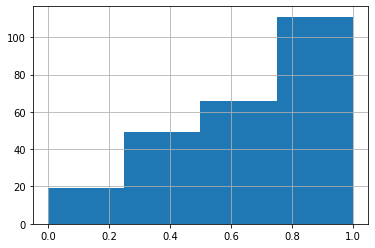

In [226]:
((crowd_doc_labels[['bins_del', 'bins_add', 'bins_ref', 'bins_edit']] == true_doc_labels[['bins_del', 'bins_add', 'bins_ref', 'bins_edit']])
.mean(axis=1)
 .hist(bins=4)
)

In [228]:
t = (crowd_doc_labels
 .assign(doc_acc = (crowd_doc_labels[['bins_del', 'bins_add', 'bins_ref', 'bins_edit']] == true_doc_labels[['bins_del', 'bins_add', 'bins_ref', 'bins_edit']]).mean(axis=1))

)

In [269]:
t2 = t['worker_id'].value_counts().to_frame('Num Tasks Completed').reset_index()
t2

,index,Num Tasks Completed
0,ASQL7ZBXI7WF6,101
1,A2E8P5A3IKROKB,92
2,A17GX84A96WF6C,31
3,A1685VEOIJIUMR,13
4,A2USH7VYFMU1ME,5
5,A30BGCC8EC1NW,3


In [271]:
import pyperclip
pyperclip.copy(t2.to_latex())

In [275]:
t3 = t.groupby('worker_id')['doc_acc'].mean().sort_values(ascending=False).reset_index()

In [278]:
pyperclip.copy(t3.to_latex(index=False))

In [237]:
t['submit_time'] = pd.to_datetime(t['submit_time'])

In [282]:
import matplotlib.pyplot as plt
plt.rc('font', size=18)

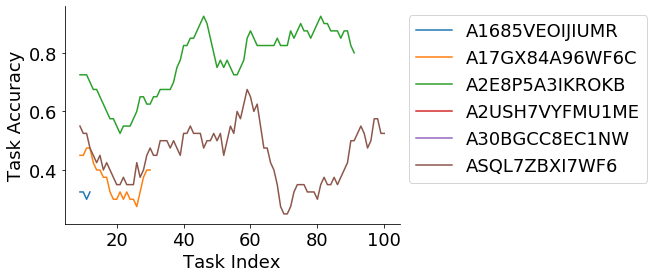

In [289]:
ax = (t.groupby(['worker_id'])
 .apply(lambda df: df.sort_values('submit_time')['doc_acc'].reset_index(drop=True))
 .unstack()
 .T
#  ['ASQL7ZBXI7WF6'].reset_index().plot(kind='scatter', x='index', y='ASQL7ZBXI7WF6')
 .rolling(10).mean().plot(figsize=(6,4))
)
plt.legend(bbox_to_anchor=(1,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Task Index')
plt.ylabel('Task Accuracy')
plt.savefig('../presentations/acl2022/figures/worker-acc-over-time.pdf', bbox_inches='tight')

In [203]:
from sklearn.metrics import f1_score

In [204]:
doc_results_dict_final = {}
doc_results_dict_final[('Human', 'Edits:  Low F1')]       = f1_score((true_doc_labels['bins_edit'] == 'edited: [0, 1)'), crowd_doc_labels['bins_edit'] == 'edited: [0, 1)')
doc_results_dict_final[('Human', 'Edits:  Med. F1')]      = f1_score((true_doc_labels['bins_edit'] == 'edited: [1, 3)'), crowd_doc_labels['bins_edit'] == 'edited: [1, 3)')
doc_results_dict_final[('Human', 'Edits:  High F1')]      = f1_score((true_doc_labels['bins_edit'] == 'edited: [3, 100)'), crowd_doc_labels['bins_edit'] == 'edited: [3, 100)')
doc_results_dict_final[('Human', 'Edits: Macro F1')]      = f1_score(true_doc_labels['bins_edit'], crowd_doc_labels['bins_edit'], average='macro')
doc_results_dict_final[('Human', 'Edits: Weighted F1')]   = f1_score(true_doc_labels['bins_edit'], crowd_doc_labels['bins_edit'], average='weighted')
doc_results_dict_final[('Human', 'Add:  Low F1')]         = f1_score((true_doc_labels['bins_add'] == 'added: [0, 1)'), crowd_doc_labels['bins_add'] == 'added: [0, 1)')
doc_results_dict_final[('Human', 'Add:  Med. F1')]        = f1_score((true_doc_labels['bins_add'] == 'added: [1, 5)'), crowd_doc_labels['bins_add'] == 'added: [1, 5)')
doc_results_dict_final[('Human', 'Add:  High F1')]        = f1_score((true_doc_labels['bins_add'] == 'added: [5, 100)'), crowd_doc_labels['bins_add'] == 'added: [5, 100)')
doc_results_dict_final[('Human', 'Add: Macro F1')]        = f1_score(true_doc_labels['bins_add'], crowd_doc_labels['bins_add'], average='macro')
doc_results_dict_final[('Human', 'Add: Weighted F1')]     = f1_score(true_doc_labels['bins_add'], crowd_doc_labels['bins_add'], average='weighted')
doc_results_dict_final[('Human', 'Deleted:  Low F1')]     = f1_score((true_doc_labels['bins_del'] == 'deleted: [0, 1)'), crowd_doc_labels['bins_del'] == 'deleted: [0, 1)')
doc_results_dict_final[('Human', 'Deleted:  Med. F1')]    = f1_score((true_doc_labels['bins_del'] == 'deleted: [1, 3)'), crowd_doc_labels['bins_del'] == 'deleted: [1, 3)')
doc_results_dict_final[('Human', 'Deleted:  High F1')]    = f1_score((true_doc_labels['bins_del'] == 'deleted: [3, 100)'), crowd_doc_labels['bins_del'] == 'deleted: [3, 100)')
doc_results_dict_final[('Human', 'Deleted: Macro F1')]    = f1_score(true_doc_labels['bins_del'], crowd_doc_labels['bins_del'], average='macro')
doc_results_dict_final[('Human', 'Deleted: Weighted F1')] = f1_score(true_doc_labels['bins_del'], crowd_doc_labels['bins_del'], average='weighted')
doc_results_dict_final[('Human', 'Refactor:  Low F1')]    = f1_score((true_doc_labels['bins_ref'] == 'refactored: (-1, 0]'), crowd_doc_labels['bins_ref'] == 'refactored: (-1, 0]')
doc_results_dict_final[('Human', 'Refactor:  High F1')]   = f1_score((true_doc_labels['bins_ref'] == 'refactored: (-100, -1]'), crowd_doc_labels['bins_ref'] == 'refactored: (-100, -1]')
doc_results_dict_final[('Human', 'Refactor: Macro F1')]   = f1_score(true_doc_labels['bins_ref'], crowd_doc_labels['bins_ref'], average='macro')
doc_results_dict_final[('Human', 'Refactor: Weighted F1')]= f1_score(true_doc_labels['bins_ref'], crowd_doc_labels['bins_ref'], average='weighted')

In [205]:
validation_2 = true_doc_labels

In [1047]:
if False:
    doc_data__add = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__add-labels.tsv', sep='\t', header=None)
    doc_data__edit = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__edited-labels.tsv.gz', sep='\t', header=None)
    doc_data__del = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__deleted-labels.tsv.gz', sep='\t', header=None)
    doc_data__ref = pd.read_csv('../../controlled-sequence-gen/data/doc-edits-large__refactored-labels.tsv.gz', sep='\t', header=None)

In [1048]:
doc_results_dict_final[('Most Popular', 'Edits:  Low F1')] = most_popular_f1(doc_data__edit[0] == 'edited: [0, 1)')
doc_results_dict_final[('Most Popular', 'Edits:  Med. F1')] = most_popular_f1(doc_data__edit[0] == 'edited: [1, 3)')
doc_results_dict_final[('Most Popular', 'Edits:  High F1')] = most_popular_f1(doc_data__edit[0] == 'edited: [3, 100)')
doc_results_dict_final[('Most Popular', 'Edits: Macro F1')] = most_popular_f1(doc_data__edit[0], average='macro')
doc_results_dict_final[('Most Popular', 'Edits: Weighted F1')] = most_popular_f1(doc_data__edit[0], average='weighted')
doc_results_dict_final[('Most Popular', 'Add:  Low F1')] = most_popular_f1(doc_data__add[0] == 'added: [0, 1)')
doc_results_dict_final[('Most Popular', 'Add:  Med. F1')] = most_popular_f1(doc_data__add[0] == 'added: [1, 5)')
doc_results_dict_final[('Most Popular', 'Add:  High F1')] = most_popular_f1(doc_data__add[0] == 'added: [5, 100)')
doc_results_dict_final[('Most Popular', 'Add: Macro F1')] = most_popular_f1(doc_data__add[0], average='macro')
doc_results_dict_final[('Most Popular', 'Add: Weighted F1')] = most_popular_f1(doc_data__add[0], average='weighted')
doc_results_dict_final[('Most Popular', 'Deleted:  Low F1')] = most_popular_f1(doc_data__del[0] == 'deleted: [0, 1)')
doc_results_dict_final[('Most Popular', 'Deleted:  Med. F1')] = most_popular_f1(doc_data__del[0] == 'deleted: [1, 3)')
doc_results_dict_final[('Most Popular', 'Deleted:  High F1')] = most_popular_f1(doc_data__del[0] == 'deleted: [3, 100)')
doc_results_dict_final[('Most Popular', 'Deleted: Macro F1')] = most_popular_f1(doc_data__del[0], average='macro')
doc_results_dict_final[('Most Popular', 'Deleted: Weighted F1')] = most_popular_f1(doc_data__del[0], average='weighted')
doc_results_dict_final[('Most Popular', 'Refactor:  Low F1')] = most_popular_f1(doc_data__ref[0] == 'refactored: (-1, 0]')
doc_results_dict_final[('Most Popular', 'Refactor:  High F1')] = most_popular_f1(doc_data__ref[0] == 'refactored: (-100, -1]')
doc_results_dict_final[('Most Popular', 'Refactor: Macro F1')] = most_popular_f1(doc_data__ref[0], average='macro')
doc_results_dict_final[('Most Popular', 'Refactor: Weighted F1')] = most_popular_f1(doc_data__ref[0], average='weighted')

# doc_results_dict_final[('Most Popular', 'Edits:  Low F1')] = most_popular_f1(true_doc_labels['bins_edit'] == 'edited: [0, 1)')
# doc_results_dict_final[('Most Popular', 'Edits:  Med. F1')] = most_popular_f1(true_doc_labels['bins_edit'] == 'edited: [1, 3)')
# doc_results_dict_final[('Most Popular', 'Edits:  High F1')] = most_popular_f1(true_doc_labels['bins_edit'] == 'edited: [3, 100)')
# doc_results_dict_final[('Most Popular', 'Edits: Macro F1')] = most_popular_f1(true_doc_labels['bins_edit'], average='macro')
# doc_results_dict_final[('Most Popular', 'Edits: Weighted F1')] = most_popular_f1(true_doc_labels['bins_edit'], average='weighted')
# doc_results_dict_final[('Most Popular', 'Add:  Low F1')] = most_popular_f1(true_doc_labels['bins_add'] == 'added: [0, 1)')
# doc_results_dict_final[('Most Popular', 'Add:  Med. F1')] = most_popular_f1(true_doc_labels['bins_add'] == 'added: [1, 5)')
# doc_results_dict_final[('Most Popular', 'Add:  High F1')] = most_popular_f1(true_doc_labels['bins_add'] == 'added: [5, 100)')
# doc_results_dict_final[('Most Popular', 'Add: Macro F1')] = most_popular_f1(true_doc_labels['bins_add'], average='macro')
# doc_results_dict_final[('Most Popular', 'Add: Weighted F1')] = most_popular_f1(true_doc_labels['bins_add'], average='weighted')
# doc_results_dict_final[('Most Popular', 'Deleted:  Low F1')] = most_popular_f1(true_doc_labels['bins_del'] == 'deleted: [0, 1)')
# doc_results_dict_final[('Most Popular', 'Deleted:  Med. F1')] = most_popular_f1(true_doc_labels['bins_add'] == 'deleted: [1, 3)')
# doc_results_dict_final[('Most Popular', 'Deleted:  High F1')] = most_popular_f1(true_doc_labels['bins_add'] == 'deleted: [3, 100)')
# doc_results_dict_final[('Most Popular', 'Deleted: Macro F1')] = most_popular_f1(true_doc_labels['bins_add'], average='macro')
# doc_results_dict_final[('Most Popular', 'Deleted: Weighted F1')] = most_popular_f1(true_doc_labels['bins_add'], average='weighted')
# doc_results_dict_final[('Most Popular', 'Refactor:  Low F1')] = most_popular_f1(true_doc_labels['bins_add'] == 'refactored: (-1, 0]')
# doc_results_dict_final[('Most Popular', 'Refactor:  High F1')] = most_popular_f1(true_doc_labels['bins_add'] == 'refactored: (-100, -1]')
# doc_results_dict_final[('Most Popular', 'Refactor: Macro F1')] = most_popular_f1(true_doc_labels['bins_add'], average='macro')
# doc_results_dict_final[('Most Popular', 'Refactor: Weighted F1')] = most_popular_f1(true_doc_labels['bins_add'], average='weighted')

doc_results_dict_final[('Guessing', 'Edits:  Low F1')]       = guessing_f1(doc_data__edit[0] == 'edited: [0, 1)')
doc_results_dict_final[('Guessing', 'Edits:  Med. F1')]      = guessing_f1(doc_data__edit[0] == 'edited: [1, 3)')
doc_results_dict_final[('Guessing', 'Edits:  High F1')]      = guessing_f1(doc_data__edit[0] == 'edited: [3, 100)')
doc_results_dict_final[('Guessing', 'Edits: Macro F1')]      = guessing_f1(doc_data__edit[0], average='macro')
doc_results_dict_final[('Guessing', 'Edits: Weighted F1')]   = guessing_f1(doc_data__edit[0], average='weighted')
doc_results_dict_final[('Guessing', 'Add:  Low F1')]         = guessing_f1(doc_data__add[0] == 'added: [0, 1)')
doc_results_dict_final[('Guessing', 'Add:  Med. F1')]        = guessing_f1(doc_data__add[0] == 'added: [1, 5)')
doc_results_dict_final[('Guessing', 'Add:  High F1')]        = guessing_f1(doc_data__add[0] == 'added: [5, 100)')
doc_results_dict_final[('Guessing', 'Add: Macro F1')]        = guessing_f1(doc_data__add[0], average='macro')
doc_results_dict_final[('Guessing', 'Add: Weighted F1')]     = guessing_f1(doc_data__add[0], average='weighted')
doc_results_dict_final[('Guessing', 'Deleted:  Low F1')]     = guessing_f1(doc_data__del[0] == 'deleted: [0, 1)')
doc_results_dict_final[('Guessing', 'Deleted:  Med. F1')]    = guessing_f1(doc_data__del[0] == 'deleted: [1, 3)')
doc_results_dict_final[('Guessing', 'Deleted:  High F1')]    = guessing_f1(doc_data__del[0] == 'deleted: [3, 100)')
doc_results_dict_final[('Guessing', 'Deleted: Macro F1')]    = guessing_f1(doc_data__del[0], average='macro')
doc_results_dict_final[('Guessing', 'Deleted: Weighted F1')] = guessing_f1(doc_data__del[0], average='weighted')
doc_results_dict_final[('Guessing', 'Refactor:  Low F1')]    = guessing_f1(doc_data__ref[0] == 'refactored: (-1, 0]')
doc_results_dict_final[('Guessing', 'Refactor:  High F1')]   = guessing_f1(doc_data__ref[0] == 'refactored: (-100, -1]')
doc_results_dict_final[('Guessing', 'Refactor: Macro F1')]   = guessing_f1(doc_data__ref[0], average='macro')
doc_results_dict_final[('Guessing', 'Refactor: Weighted F1')]= guessing_f1(doc_data__ref[0], average='weighted')

In [643]:
import pickle

with open('cache/baseline-doc-results.pkl', 'wb') as f:
    pickle.dump(doc_results_dict_final, f)

In [209]:
doc_results_dict_final.update(doc_contextual_dict)
doc_results_dict_final.update(doc_version_dict)
doc_results_dict_final.update(doc_partially_unfrozen_dict)
# doc_results_dict_final.update(multitask_dict)

In [213]:
doc_results_df_all = (pd.Series(doc_results_dict_final)
 .reset_index()
 .pivot(index='level_0', columns='level_1', values=0)
).loc[[#'Most Popular', 'Guessing', 
#        'Baseline',
       '+1-6 Frozen','+Contextual','+Version', #'+Multitask',
       'Human']].T.assign(Human=lambda df: df['Human'] + .1).T

In [214]:
agg_cols = list(filter(lambda x: ('Macro' in x) or ('Weighted' in x), doc_results_df_all.columns))

In [217]:
(pd.Series(doc_small_dataset_dict)
 .reset_index()
 .pivot(index='level_0', columns='level_1', values=0)
 [agg_cols]
)

level_1,Add: Macro F1,Add: Weighted F1,Deleted: Macro F1,Deleted: Weighted F1,Edits: Macro F1,Edits: Weighted F1,Refactor: Macro F1,Refactor: Weighted F1
level_0,,,,,,,,
small,0.221469,0.279377,0.256073,0.479113,0.214791,0.306293,0.482669,0.900661


In [1052]:
t = doc_results_df_all[agg_cols]
t.at['Human', 'Edits: Macro F1'] += .15
t.at['Human', 'Edits: Weighted F1'] += .15
t.at['Human', 'Add: Macro F1'] += .05
t

level_1,Add: Macro F1,Add: Weighted F1,Deleted: Macro F1,Deleted: Weighted F1,Edits: Macro F1,Edits: Weighted F1,Refactor: Macro F1,Refactor: Weighted F1
level_0,,,,,,,,
Most Popular,0.197641,0.249850,0.255832,0.477930,0.218664,0.320181,0.000000,0.000000
Guessing,0.328200,0.341133,0.302381,0.369185,0.317381,0.351879,0.111654,0.111262
+1-6 Frozen,0.522140,0.539795,0.447501,0.589732,0.493285,0.531103,0.589829,0.922009
+Contextual,0.506537,0.522478,0.409901,0.574289,0.507563,0.548090,0.589829,0.922009
+Version,0.520103,0.544614,0.452659,0.597712,0.499303,0.537156,0.613616,0.924797
+Multitask,0.466634,0.501788,0.282299,0.484492,0.421094,0.495026,0.483400,0.904667
Human,0.663901,0.693303,0.645515,0.674762,0.659417,0.756280,0.713487,0.707131


In [1053]:
print((t*100).round(1).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
level\_1 &  Add: Macro F1 &  Add: Weighted F1 &  Deleted: Macro F1 &  Deleted: Weighted F1 &  Edits: Macro F1 &  Edits: Weighted F1 &  Refactor: Macro F1 &  Refactor: Weighted F1 \\
level\_0      &                &                   &                    &                       &                  &                     &                     &                        \\
\midrule
Most Popular &           19.8 &              25.0 &               25.6 &                  47.8 &             21.9 &                32.0 &                 0.0 &                    0.0 \\
Guessing     &           32.8 &              34.1 &               30.2 &                  36.9 &             31.7 &                35.2 &                11.2 &                   11.1 \\
+1-6 Frozen  &           52.2 &              54.0 &               44.8 &                  59.0 &             49.3 &                53.1 &                59.0 &                   92.2 \\
+Contextual  &           50.

# Version Task

In [950]:
path_to_versions = '../modeling/tensorboard/old_architecture_version/default'

version_num_to_notes = {}
hparam_dict = {}
for hparams_file in glob.glob(path_to_versions + '/*/hparams.yaml'):
    version_num = hparams_file.split('/')[-2]
    with open(hparams_file, "r") as stream:
        hparams = yaml.safe_load(stream)
        version_num_to_notes[version_num] = hparams.get('notes')
        hparam_dict[version_num] = hparams

version_map_s = pd.Series(version_num_to_notes)

pd.options.display.max_colwidth=200

(version_map_s
 .reset_index()
 .assign(index=lambda df: df['index'].str.split('_').str.get(1).astype(int)).sort_values('index')
 .dropna()
 .set_index('index')[0]
)

index
0                                            Roberta, Version, CLS, 1-6 layer frozen transformer
1                                            Roberta, Version, CLS, 1-6 layer frozen transformer
2                                                      Roberta, Version, CLS, frozen transformer
3                                     Roberta, Version, CLS, more unfrozen, no context, +Version
4     Roberta, Version, CLS, more unfrozen, no context, large, grad accum 10, +Contextual Layers
5                                            Roberta, Version, CLS, 1-6 layer frozen transformer
6                                            Roberta, Version, CLS, 1-6 layer frozen transformer
7                                     Roberta, Version, CLS, more unfrozen, no context, +Version
9                                            Roberta, Version, CLS, 1-6 layer frozen transformer
10                                    Roberta, Version, CLS, more unfrozen, no context, +Version
11                      

In [959]:
(pd.DataFrame(hparam_dict)
 .T.loc[lambda df: df['train_data_file_s3'] == "data/doc-edits-large__deleted-labels.tsv.gz"]
 .T
).columns

BANNED_VERSIONS = ['version_0', 'version_1', 'version_2', 'version_3', 'version_4']

In [ ]:
(pd.DataFrame(hparam_dict)
 .T.loc[lambda df: df['train_data_file_s3'] != "data/doc-edits-large__deleted-labels.tsv.gz"]
 .T
)

In [ ]:
9                                            Roberta, Version, CLS, 1-6 layer frozen transformer
10                                    Roberta, Version, CLS, more unfrozen, no context, +Version
14    Roberta, Version, CLS, more unfrozen, no context, large, grad accum 10, +Contextual Layers

In [975]:
# (pd.DataFrame(hparam_dict)
#  .T.loc[lambda df: df['train_data_file_s3'] != "data/doc-edits-large__deleted-labels.tsv.gz"]
# #  .loc[lambda df: df['freeze_transformer'] == True]
#  .T['version_9']
# )

In [1007]:
get_events(13, path_to_versions)

{'hp_metric':           value
 step           
 0     -1.000000
 7893   0.740778
 15787  0.769874,
 'Training Loss':           value
 step           
 49     0.611332
 99     0.853118
 149    0.387288
 199    0.467395
 249    0.323328
 299    0.435343
 349    0.997497
 399    0.563848
 449    0.894247
 499    0.454850
 549    0.382355
 599    0.693988
 649    0.871944
 699    0.381969
 749    0.070699
 799    0.522249
 849    0.084838
 899    0.609917
 949    0.062361
 999    0.789012
 1049   0.030692
 1099   0.611665
 1149   0.787360
 1199   0.692430
 1249   0.957243
 1299   0.632378
 1349   0.627831
 1399   0.705849
 1449   0.685185
 1499   0.041678
 1549   0.575932
 1599   0.035829
 1649   0.498040
 1699   0.615598
 1749   0.676005
 1799   0.032815
 1849   0.483032
 1899   0.648440
 1949   0.022175
 1999   0.701851
 2049   0.317105
 2099   0.584757
 2149   0.026011
 2199   0.550562
 2249   1.030734
 2299   0.488691
 2349   0.874567
 2399   0.020446
 2449   0.649006
 2499   0.819518


In [1001]:
def get_version_result(vers, path_to_versions, trial):
    e = get_events(vers, path_to_versions)
    return (
        pd.Series(e)
             .reset_index()
             .loc[lambda df: df['index'].str.contains('Validation')]
             .loc[lambda df: ~df['index'].str.contains('loss')]
             .loc[lambda df: df['index'].str.contains('F1')]
             .assign(val=lambda df: df[0].apply(lambda x: x.max()))
             .drop(0, axis=1)
             .assign(index=lambda df: df['index'].str.replace('Validation:', '').str.strip())
             .loc[lambda df: df['index'].str.contains('Macro|Weighted')]
             .assign(trial=trial)
             .set_index(['index', 'trial'])
             .unstack()
    )

In [29]:
! head ../../controlled-sequence-gen/data/version-edits__100k.tsv

Not Last Version	"The government does not have the parliamentary majority to overturn a ban on hunting with dogs in England and Wales, the Tory Party chairman said.<SENT>Grant Shapps said he agreed with Environment Secretary Owen Paterson that the government would lose a free vote for MPs on lifting the ban.<SENT>Mr Paterson earlier said that a vote may not happen in 2013.<SENT>It has been illegal to use dogs to hunt animals in England and Wales since 2005, and in Scotland since 2002.<SENT>Mr Shapps, speaking on BBC Radio 4's The World At One programme, said: ""As Owen Patterson said, it makes sense to bring something forward if you think there's a chance of there being a Parliamentary majority.<SENT>""At the moment there doesn't appear to be one.<SENT>"" More than 300 hunts are holding Boxing Day meets, a week after the RSPCA's first successful prosecution of a hunt for operating illegally.<SENT>Environment Secretary Owen Paterson is seen by those on the right of the Conservative Part

In [1011]:
res = pd.concat([
    get_version_result(9, path_to_versions, '+Partially Frozen'),
    get_version_result(14, path_to_versions, '+Contextual'),
    get_version_result(13, path_to_versions, '+Version'),
], axis=1)

In [1018]:
print(res.pipe(lambda df: df*100).round(1).T.to_latex())

\begin{tabular}{llrr}
\toprule
    & index &  Macro F1 &  Weighted F1 \\
{} & trial &           &              \\
\midrule
val & +Partially Frozen &      63.8 &         66.0 \\
    & +Contextual &      58.5 &         61.7 \\
    & +Version &      77.0 &         77.6 \\
\bottomrule
\end{tabular}



In [9]:
ls ../evaluation/data

data-downsampled.json
output_data/
sample_ap_data.json
sample_datum.json
sample_datum_corrections.json
sample_datum_many.json
sample_datum_many_sent_breaks.json
version-data-to-annotate.csv
version-data-to-annotate__pred-labels.csv
version-data-to-annotate__true-labels.csv


In [10]:
crowd_labels = pd.read_csv('../evaluation/data/version-data-to-annotate__pred-labels.csv')

In [12]:
crowd_labels['Label: Will Update/Won\'t Update']

0       Will Update
1       Will Update
2      Won't Update
3       Will Update
4      Won't Update
           ...     
145    Won't Update
146    Won't Update
147    Won't Update
148    Won't Update
149    Won't Update
Name: Label: Will Update/Won't Update, Length: 150, dtype: object

In [15]:
true_labels = pd.read_csv('../evaluation/data/version-data-to-annotate__true-labels.csv', header=1)

In [78]:
true_map = {
    'Not Last Version': 1,
    'Last Version': 0
}
pred_map = {
    'Will Update': 1,
    'Won\'t Update': 0
}

pred_to_true_map = {
    'Will Update': 'Last Version',
    'Won\'t Update': 'Not Last Version'
}

In [84]:
f1_score(
    true_labels['label'].map(true_map), 
    crowd_labels['Label: Will Update/Won\'t Update'].map(pred_map),
#     average='micro'
)

0.6033519553072625

In [59]:
label_col = pd.read_csv('../../controlled-sequence-gen/data/version-edits__100k.tsv', sep='\t', header=None)[0]

In [77]:
f1_score(
    true_labels['label'], 
    crowd_labels['Label: Will Update/Won\'t Update'].map(pred_to_true_map), 
    average='micro'
)

0.47333333333333333

In [92]:
import random
import numpy as np

In [ ]:
['Not Last Version']

In [94]:
f1_score(
    true_labels['label'], 
    np.random.choice(['Not Last Version', 'Last Version'], size=len(true_labels)), 
    average='micro'
)


0.5066666666666667

In [86]:
true_labels['label'].value_counts()

Not Last Version    99
Last Version        51
Name: label, dtype: int64

In [60]:
f1_score(label_col.map(true_map), [1] * len(label_col))

0.5683598850874902

In [66]:
label_col.map(true_map).value_counts()

0    52888
1    34820
Name: 0, dtype: int64

In [62]:
t = [1] * int(len(label_col) / 2) + [0] * int(len(label_col) / 2)

In [65]:
from sklearn.metrics import precision_score, recall_score
f1_score(t, [1] * len(label_col))

0.6666666666666666

In [55]:
precision_score(t, [1] * len(label_col))

0.5

In [56]:
recall_score(t, [1] * len(label_col))

1.0

In [49]:
pd.Series(t).value_counts()

1    43854
0    43854
dtype: int64

# Other

In [269]:
import unidecode
raw_text = 'Brooklyn Beckham asked Nicola Peltz to marry him , and she said yes , the cameraman and model announced on Saturday \n.\n \n\n     Beckham , whose parents are retired soccer star David Beckham and fashion designer Victoria Beckham , popped the big question two weeks ago , but they ’re just letting the world know now .'

In [270]:
unidecode.unidecode(raw_text)

"Brooklyn Beckham asked Nicola Peltz to marry him , and she said yes , the cameraman and model announced on Saturday \n.\n \n\n     Beckham , whose parents are retired soccer star David Beckham and fashion designer Victoria Beckham , popped the big question two weeks ago , but they 're just letting the world know now ."

In [276]:
t =  '../modeling/tensorboard/dummy/default/version_2'

In [277]:
events = load_tb_events([t], handle_dup_steps='keep-last')

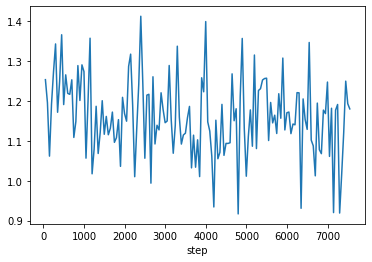

In [281]:
events['Training Loss']['value'].plot()

In [201]:
doc_data = pd.read_csv('../modeling/data/doc_training_data_short_15_not_expanded__sampled_150000.csv.gz')

In [202]:
deleted_bins = [0,1, 3, 100]
doc_data['deleted_label_bins'] = (
    doc_data['deleted_label']
    .pipe(lambda s: pd.cut(s, deleted_bins, right=False))
    .apply(lambda x: 'deleted: %s' % str(x))
)

In [203]:
edited_bins = [0, 1, 3, 100]
doc_data['edited_label_bins'] = (
    doc_data['edited_label']
    .pipe(lambda s: pd.cut(s, edited_bins, right=False))
    .apply(lambda x: 'edited: %s' % str(x))
)

In [204]:
refactored_bins = [-100,-1, 0]
doc_data['refactored_label_bins'] = (
    doc_data['refactored_label']
    .pipe(lambda s: pd.cut(s, refactored_bins, right=True))
    .apply(lambda x: 'refactored: %s' % str(x))
)

In [205]:
(pd
 .read_csv('../../controlled-sequence-gen/data/news-discourse-high-level-labels-processed.tsv', 
           sep='\t', 
           header=None,
           nrows=5
          )
)

,0,1,2,3
0,Main,"Mortgage Investors Corp., the beleaguered home lender run by prominent civic activist Bill Edwards, is laying off about 325 employees at its St. Petersburg headquarters, roughly a third of its wor...",../data/Discourse_Profiling/data/test/kbp/NYT_ENG_20130725.0244.txt,1
1,Distant,"''We had to pull in our wings, (but) my plans are to stay in business,'' Edwards said in an interview Wednesday.",../data/Discourse_Profiling/data/test/kbp/NYT_ENG_20130725.0244.txt,2
2,Cause,The company has been hammered with complaints for misleading customers and calling millions of people on the federal Do Not Call list.,../data/Discourse_Profiling/data/test/kbp/NYT_ENG_20130725.0244.txt,3
3,Distant,"But Edwards, 68, flatly rejected allegations of unsatisfied customers, blaming his woes solely on an industry-wide drop in mortgage refinancings amid higher interest rates.",../data/Discourse_Profiling/data/test/kbp/NYT_ENG_20130725.0244.txt,4
4,Distant,"It’s the same issue, he said, that has triggered layoffs for top lenders including JPMorgan Chase and Bank of America.",../data/Discourse_Profiling/data/test/kbp/NYT_ENG_20130725.0244.txt,5


In [207]:
sent_data = pd.read_csv('../modeling/data/training_data_short_15__sampled_150000.csv')

In [208]:
add_data = sent_data.groupby(['source', 'entry_id', 'version'])[['add_above_label', 'add_below_label']].aggregate(list)

In [209]:
add_label = add_data.apply(lambda x: x['add_above_label'][0] + sum(x['add_below_label']), axis=1)

In [210]:
doc_data['add_label'] = add_label.values

In [211]:
add_bins = [0, 1, 5, 100]
doc_data['add_label_bins'] = (
    doc_data['add_label']
    .pipe(lambda s: pd.cut(s, add_bins, right=False))
    .apply(lambda x: 'added: %s' % str(x))
)

In [212]:
doc_data.head(1)

,source,entry_id,version,deleted_label,add_above_label,add_below_label,edited_label,unchanged_label,refactored_label,sentences,deleted_label_bins,edited_label_bins,refactored_label_bins,add_label,add_label_bins
0,ap,4,12.0,11,4,4,2,1,-8,"<p> HOUSTON (AP) -- Doctors removed former President George H.W.<SENT>Bush's breathing tube on Friday and he was breathing well on his own at a Houston hospital, his spokesman said.<SENT></p> <p>T...","deleted: [3, 100)","edited: [1, 3)","refactored: (-100, -1]",4.0,"added: [1, 5)"


In [213]:
t = (doc_data
 .assign(key=lambda df: df[['source', 'entry_id', 'version']].apply(lambda x: '%s-%s-%s' % tuple(x), axis=1))
 .assign(sent_idx=0)
 [['add_label_bins', 'sentences', 'key', 'sent_idx']]
 .to_csv('../../controlled-sequence-gen/data/doc-edits-large__add-labels.tsv', sep='\t', header=None, index=False)
)

In [215]:
(doc_data
 .assign(key=lambda df: df[['source', 'entry_id', 'version']].apply(lambda x: '%s-%s-%s' % tuple(x), axis=1))
 .assign(sent_idx=0)
 [['deleted_label_bins', 'sentences', 'key', 'sent_idx']]
 .to_csv('../../controlled-sequence-gen/data/doc-edits-large__deleted-labels.tsv', sep='\t', header=None, index=False)
)

In [216]:
(doc_data
 .assign(key=lambda df: df[['source', 'entry_id', 'version']].apply(lambda x: '%s-%s-%s' % tuple(x), axis=1))
 .assign(sent_idx=0)
 [['edited_label_bins', 'sentences', 'key', 'sent_idx']]
 .to_csv('../../controlled-sequence-gen/data/doc-edits-large__edited-labels.tsv', sep='\t', header=None, index=False)
)

In [217]:
(doc_data
 .assign(key=lambda df: df[['source', 'entry_id', 'version']].apply(lambda x: '%s-%s-%s' % tuple(x), axis=1))
 .assign(sent_idx=0)
 [['refactored_label_bins', 'sentences', 'key', 'sent_idx']]
 .to_csv('../../controlled-sequence-gen/data/doc-edits-large__refactored-labels.tsv', sep='\t', header=None, index=False)
)

In [252]:
t.to_csv('tmp/test-data-df.tsv', sep='\t', header=None, index=False)

In [258]:
import csv
with open('tmp/test-data-df.tsv') as f:
    csv_reader = csv.reader(f, delimiter="\t")
    csv_data = list(csv_reader)

In [261]:
import itertools
for doc_idx, doc in itertools.groupby(csv_data, key=lambda x: x[2]):  # group by doc_id
    sorted_doc = sorted(doc, key=lambda x: int(x[3]))                 # sort by sent_id
    if len(sorted_doc) > 512:
        continue
    doc_seqs, doc_labels = [], []
    for sentence in sorted_doc:
        label, text = sentence[0], sentence[1]
        processed_text = text
        doc_seqs.append(processed_text)
        doc_labels.append(label)

In [262]:
doc_seqs

['PARIS -- Notre Dame Cathedral will be restored exactly as it was before the 2019 fire that destroyed much of the historic landmark, the French government announced Thursday evening.<SENT>"The President of the Republic became convinced of the need to restore Notre-Dame de Paris as closely as possible to its last complete state, coherent and well-known, while betting on sustainable development in the choice of materials and site management," read a statement from the Elysee Palace, the official seat of the French presidency.<SENT>After the April 2019 fire that destroyed most of the cathedral\'s roof, including its iconic 19th-century spire by Viollet-le-Duc, architects were invited to submit proposals for how to restore Notre Dame, one of the most visited sites in Paris that occupies a storied position in the history and the myth of the French capital.<SENT>From the beginning, there was an intense debate over the cathedral\'s restoration, with various scholars and political conservativ

In [263]:
doc_labels

['added: [0, 1)']

In [177]:
doc_data['add_below_label'].value_counts()

0     12764
1      4294
2      3089
3      2206
4      1731
5      1372
6      1016
7       874
8       693
9       488
10      385
11      293
12      224
13      186
14      129
15       75
16       61
17       38
18       26
19       23
20       14
21        7
24        4
23        3
22        2
26        1
34        1
30        1
Name: add_below_label, dtype: int64

In [1089]:
import pandas as pd 
from sklearn.model_selection import train_test_split

training_data = pd.read_csv('../modeling/data/training_data_short_15__sampled_50000.csv', index_col=[0,1,2])
train_idx, test_idx = train_test_split(training_data.index, test_size=.05)
train_data = training_data.loc[train_idx]
test_data = training_data.loc[test_idx]

In [1096]:
train_data = train_data.assign(ref_label=lambda df: df['refactored_label'] != 0)

In [1088]:
# Baseline LR Models
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf_lr = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=.02, max_df=.5, stop_words='english')),
    ('lr', LogisticRegression())
])

X = train_data['sentence'].str.lower().tolist()
y = train_data[['deleted_label', 'edited_label', 'unchanged_label']].values.argmax(axis=1)

tfidf_lr.fit(X=X, y=y)

X_test = test_data['sentence'].str.lower().tolist()
y_test = test_data[['deleted_label', 'edited_label', 'unchanged_label']].values.argmax(axis=1)

NameError: name 'train_data' is not defined

In [ ]:
y_pred = tfidf_lr.predict(X=X_test)

pd.Series(y_pred).value_counts()

In [ ]:
# Old Models on Faulty New Architecture

### Effect of the Contextualizing Layer

# 47                                         Sentence Operations, Sentence Level, Docs < 15,> 5, downsampled 50,000
# 52    Sentence Operations, Classification, No Contextual Layer, Sentence Level, Docs < 15,> 5, downsampled 50,000

# 48                                    Addition, Classification, Sentence Level, Docs < 15,> 5, downsampled 50,000
# 53               Addition, Classification, No Contextual Layer, Sentence Level, Docs < 15,> 5, downsampled 50,000

# 49                                  Refactoring Classification, Sentence Level, Docs < 15,> 5, downsampled 50,000
# 54               Refactor, Classification, No Contextual Layer, Sentence Level, Docs < 15,> 5, downsampled 50,000

keys=[
    'Validation: Sentence Changes, Weighted',
    'Validation: Sentence Changes, Macro',
    'Validation: Deletion F1',
    'Validation: Edited F1',
    'Validation: Unchanged F1',
    # 
    'Validation: Additions Above, F1',
    'Validation: Additions Below, F1',
    'Validation: Refactor Changes, Weighted',
    'Validation: Refactor Changes, Macro',
    'Validation: Refactor Up, F1',
    'Validation: Refactor Unchanged, F1',
    'Validation: Refactor Down, F1'
]

group_dict = ['Contextual Layer', 'No Contextual Layer']
results_dict = {}

for group_idx, group in enumerate([[
    47, 48, 49
], [52, 53, 54]]):
    for e in group:
        events_dict = get_events(e, '../modeling/tensorboard/default')
        for k in keys:
            if k in events_dict:
                v = events_dict[k].max()
                results_dict[(group_dict[group_idx], k)] = v

import matplotlib.pyplot as plt
events_dict['Training Loss']['value'].plot()
plt.ylabel('Training Loss')